### Importing libraries

In [76]:
#!pip install dtreeviz
#!brew install libomp
# pip install azure-cognitiveservices-search-imagesearch

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from typing import List
from torch.optim import Adam
import torch.nn.functional as F

from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from utils import *

import seaborn as sns
from dtreeviz.trees import *

### loading and understanding dataset

In [2]:
df = pd.read_csv('districts_without_ID.csv', low_memory=False)
df.drop(columns = 'Unnamed: 0', inplace=True)
df.columns

Index(['st_area(sh', 'st_length(', 'Confirmed', 'Active', 'Recovered',
       'Deceased', 'Zone', 'Population', 'Temperature', 'Relative Humidity',
       'Pressure', 'Wind speed', 'Wind direction', 'Rainfall', 'Snowfall',
       'Snow Depth', 'Short-wave irradiation'],
      dtype='object')

In [3]:
df.head()

,st_area(sh,st_length(,Confirmed,Active,Recovered,Deceased,Zone,Population,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Snowfall,Snow Depth,Short-wave irradiation
0,1.353967e+10,8.464308e+05,50098,5387,43426,1285,-1,3679936.0,308.37,23.87,966.23,4.70,315.61,0.001023,0.0,0.0,7387.116
1,1.771358e+10,9.720056e+05,82865,13676,67784,1405,-1,4993796.0,304.67,39.49,946.62,3.85,299.27,0.016242,0.0,0.0,6881.692
2,1.294532e+10,7.410244e+05,11822,3574,8091,157,0,2071101.0,309.31,23.72,979.54,0.56,279.09,0.000001,0.0,0.0,7552.757
3,1.547940e+10,1.014942e+06,9472,1510,7702,260,-1,2077144.0,309.29,20.82,969.33,1.24,300.10,0.000001,0.0,0.0,7178.965
4,1.186387e+10,1.131732e+06,17148,4312,12390,446,0,2876259.0,308.89,22.19,961.30,0.42,358.68,0.000028,0.0,0.0,6800.252


In [4]:
df.dtypes

st_area(sh                float64
st_length(                float64
Confirmed                   int64
Active                      int64
Recovered                   int64
Deceased                    int64
Zone                        int64
Population                 object
Temperature               float64
Relative Humidity         float64
Pressure                  float64
Wind speed                float64
Wind direction            float64
Rainfall                  float64
Snowfall                  float64
Snow Depth                float64
Short-wave irradiation    float64
dtype: object

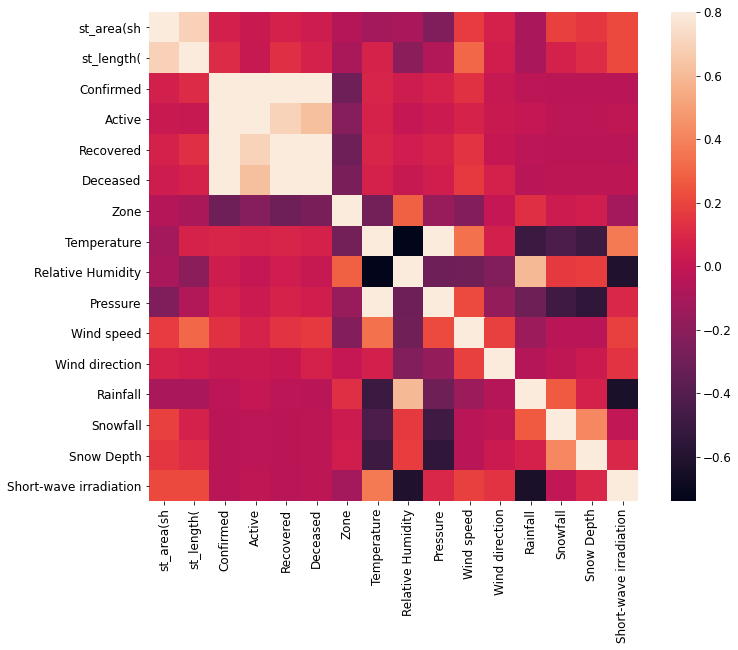

In [5]:
correlation_matrix = df.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

### Pre-processing

In [6]:
def convert_str_to_float(s):
    s_new = s.replace(',', '')
    return float(s_new)

In [7]:
df['Population'] = df['Population'].apply(convert_str_to_float)

In [8]:
ss = StandardScaler()
for col in df.columns:
    if(col != 'Zone'):
        df[col] = ss.fit_transform(df[col].values.reshape(-1, 1))

In [1]:
df['Zone'] = df['Zone'].apply(lambda x: x + 1)
# The labels are supposed to start from 0 to work with pytorch

In [9]:
df.head()

,st_area(sh,st_length(,Confirmed,Active,Recovered,Deceased,Zone,Population,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Snowfall,Snow Depth,Short-wave irradiation
0,0.833805,1.034626,1.808586,0.819825,1.930220,2.178445,-1,1.317417,1.010754,-1.367494,0.142530,2.526869,0.971593,-0.532420,-0.105543,-0.104627,0.816620
1,1.265520,1.449667,3.246962,2.575720,3.229629,2.405952,-1,2.195896,0.371724,-0.501618,-0.176366,1.831552,0.794999,-0.524425,-0.105543,-0.104627,0.089719
2,0.772331,0.686244,0.128381,0.435769,0.045229,0.039883,0,0.241710,1.173102,-1.375809,0.358977,-0.859733,0.576905,-0.532957,-0.105543,-0.104627,1.054844
3,1.034435,1.591577,0.025223,-0.001457,0.024478,0.235159,-1,0.245750,1.169648,-1.536567,0.192942,-0.303480,0.803969,-0.532957,-0.105543,-0.104627,0.517257
4,0.660475,1.977584,0.362177,0.592103,0.274565,0.587795,0,0.780058,1.100564,-1.460622,0.062359,-0.974256,1.437069,-0.532943,-0.105543,-0.104627,-0.027408


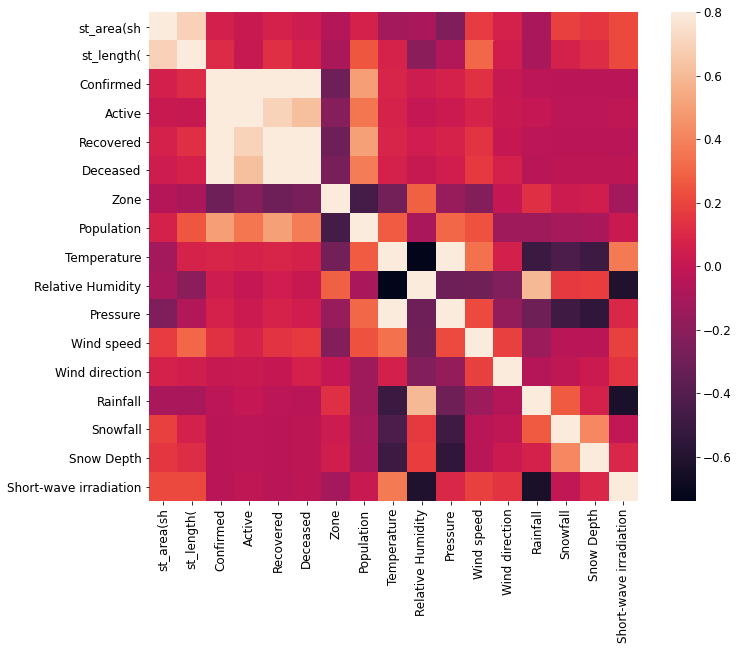

In [10]:
correlation_matrix = df.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=0.8,square = True)
plt.show()

In [11]:
split = ( list(range(80*len(df) // 100)), list(set(range(len(df))) - set(range(80*len(df) // 100))) )
cont_var = [i for i in df.columns if i!='Zone']

In [12]:
to = TabularPandas(df, cont_names=cont_var, y_names='Zone', splits=split)

In [13]:
to.train.xs

,st_area(sh,st_length(,Confirmed,Active,Recovered,Deceased,Population,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Snowfall,Snow Depth,Short-wave irradiation
0,0.833805,1.034626,1.808586,0.819825,1.930220,2.178445,1.317417,1.010754,-1.367494,0.142530,2.526869,0.971593,-0.532420,-0.105543,-0.104627,0.816620
1,1.265520,1.449667,3.246962,2.575720,3.229629,2.405952,2.195896,0.371724,-0.501618,-0.176366,1.831552,0.794999,-0.524425,-0.105543,-0.104627,0.089719
2,0.772331,0.686244,0.128381,0.435769,0.045229,0.039883,0.241710,1.173102,-1.375809,0.358977,-0.859733,0.576905,-0.532957,-0.105543,-0.104627,1.054844
3,1.034435,1.591577,0.025223,-0.001457,0.024478,0.235159,0.245750,1.169648,-1.536567,0.192942,-0.303480,0.803969,-0.532957,-0.105543,-0.104627,0.517257
4,0.660475,1.977584,0.362177,0.592103,0.274565,0.587794,0.780058,1.100564,-1.460622,0.062359,-0.974256,1.437069,-0.532943,-0.105543,-0.104627,-0.027408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,0.076504,-0.207923,-0.304664,-0.146352,-0.327021,-0.223646,-0.824256,-1.935691,0.837663,-2.224558,-0.859733,1.137271,0.605258,-0.105543,-0.104418,-3.137469
568,-0.490434,-1.114948,-0.299308,-0.289340,-0.285251,-0.197104,-0.965252,-2.636897,1.001192,-3.071317,-1.096959,0.532162,1.284775,-0.105543,-0.103793,-2.380617
569,-0.390870,-0.638833,-0.288861,-0.303109,-0.269674,-0.176249,-0.860131,-2.569540,0.934118,-3.028060,-0.957895,0.861789,1.081636,-0.105543,-0.104140,-2.203939
570,-0.167908,-0.528054,-0.262347,-0.209690,-0.260765,-0.183832,-0.729023,-1.348475,0.623134,-1.558794,-0.393462,1.201143,0.143193,-0.105543,-0.104627,-2.077529


In [14]:
train_xs, train_y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

### Decision Trees

In [15]:
DT = DecisionTreeClassifier()
DT.fit(train_xs, train_y)

DecisionTreeClassifier()

In [16]:
DT.get_n_leaves(), DT.get_depth()

(130, 19)

In [17]:
to.show(4)

,st_area(sh,st_length(,Confirmed,Active,Recovered,Deceased,Population,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Snowfall,Snow Depth,Short-wave irradiation,Zone
0,0.833805,1.034626,1.808586,0.819825,1.930220,2.178445,1.317417,1.010754,-1.367494,0.142530,2.526869,0.971593,-0.532420,-0.105543,-0.104627,0.816620,-1
1,1.265520,1.449667,3.246962,2.575720,3.229629,2.405952,2.195896,0.371724,-0.501618,-0.176366,1.831552,0.794999,-0.524425,-0.105543,-0.104627,0.089719,-1
2,0.772331,0.686244,0.128381,0.435769,0.045229,0.039883,0.241710,1.173102,-1.375809,0.358977,-0.859733,0.576905,-0.532957,-0.105543,-0.104627,1.054844,0
3,1.034435,1.591577,0.025223,-0.001457,0.024478,0.235159,0.245750,1.169648,-1.536567,0.192942,-0.303480,0.803969,-0.532957,-0.105543,-0.104627,0.517257,-1


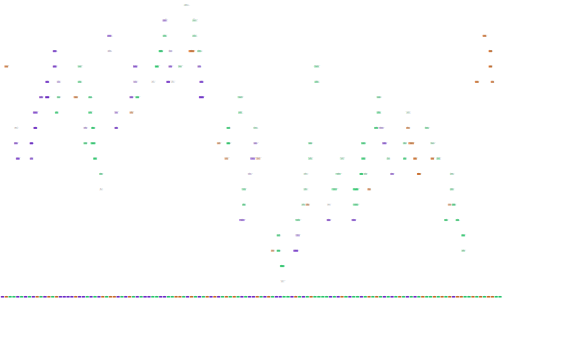

In [18]:
draw_tree(DT, train_xs, size=8, leaves_parallel=True, precision=2)

In [19]:
# samp_idx = np.random.permutation(len(train_y))[:500]
# dtreeviz(DT, train_xs.iloc[samp_idx], train_y.iloc[samp_idx], train_xs.columns, cont_var,
#         fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
#         orientation='LR')

In [20]:
def rmse(pred, y): return round(np.abs(pred-y).mean(), 6)
def model_rmse(model, xs, y): return rmse(model.predict(xs), y)

In [21]:
model_rmse(DT, train_xs, train_y)

0.0

In [22]:
model_rmse(DT, valid_xs, valid_y)

0.34965

In [23]:
DT.get_n_leaves(), len(train_xs)

(130, 572)

In [24]:
minm_config = dict()
min_loss = 1.0
for msf in range(1, 30):
    DT = DecisionTreeClassifier(min_samples_leaf=msf) 
    DT.fit(train_xs, train_y)
    valid_loss = model_rmse(DT, valid_xs, valid_y)
    if valid_loss < min_loss:
        min_loss = valid_loss
        minm_config['min_sample_leaf'] = msf
        minm_config['validation_rmse'] = valid_loss
        
minm_config

{'min_sample_leaf': 14, 'validation_rmse': 0.27972}

In [25]:
DT.get_n_leaves()

15

### Random Forest

In [26]:
def rf(xs, y, n_estimators=40, max_samples=570,
       max_features=0.5, min_samples_leaf=10, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [27]:
RF = rf(train_xs, train_y)

In [28]:
model_rmse(RF, train_xs, train_y), model_rmse(RF, valid_xs, valid_y)

(0.225524, 0.265734)

### Using Fastai and Pytorch

In [29]:
# to create a custom dataset, we need to specify __len__ and __getit

class DistrictDataset(Dataset):
    
    def __init__(self, DataFrame, dep_var, idep_var, transform=None,):
        self.transform = transform 
        self.df = DataFrame
        self.transform = transform
        self.dep_var = dep_var
        self.idep_var = idep_var
        
    def __len__(self):
        return(len(self.df))
    
    def __getitem__(self, idx):
        if(isinstance(idx, np.ndarray)):
            idx = idx.tolist()   
        elif(torch.is_tensor(idx)):
            idx = idx.tolist()
            
        x = df[self.idep_var].iloc[idx]
        target = df[self.dep_var].iloc[idx]
        
        sample = {'features': np.array(x, dtype=np.float64),
                'targets': np.array(target, dtype=np.int)} 
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [30]:
df_train = df.iloc[split[0]]
df_valid = df.iloc[split[1]]

In [31]:
class ToTensor(object):
    
    def __call__(self, sample):
        return {'features': torch.from_numpy(sample['features']),
                 'targets': torch.from_numpy(sample['targets'])}

In [32]:
dls = TabularDataLoaders.from_df(df, cont_names=cont_var, 
                                 valid_idx=list(set(range(len(df))) - set(range(80*len(df) // 100))),
                                y_names='Zone')

dls.show_batch()

df.Zone.unique()

,st_area(sh,st_length(,Confirmed,Active,Recovered,Deceased,Population,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Snowfall,Snow Depth,Short-wave irradiation,Zone
0,-0.045106,0.181122,-0.214104,-0.245067,-0.193655,-0.168665,0.706172,-0.104957,0.307161,0.591360,0.359116,-1.378916,-0.439999,-0.105543,-0.104627,-0.467729,0.0
1,-0.529106,-1.065481,-0.338025,-0.076235,-0.385168,-0.225542,-0.861912,-0.911517,0.727350,-0.629749,-0.794291,0.763441,1.295065,-0.105543,-0.104627,-1.044145,1.0
2,-0.560717,-1.647689,-0.388902,-0.313277,-0.386395,-0.257772,-0.001252,0.578977,-0.843644,0.372962,-1.096959,0.538971,-0.532815,-0.105543,-0.104627,0.799770,-1.0
3,0.129039,0.401065,0.517046,0.072685,0.601738,0.297724,2.838174,0.299186,-0.500509,0.574935,-0.761571,-0.671246,-0.532939,-0.105543,-0.104627,0.732959,0.0
4,-0.057260,-0.241086,-0.291934,-0.297813,-0.272928,-0.240709,-0.258634,0.154109,-0.484433,0.137327,-0.565246,1.259611,-0.530881,-0.105543,-0.104627,1.093552,0.0
5,0.028636,-0.170124,-0.368007,-0.309252,-0.362763,-0.231230,-0.578044,0.758596,-1.523817,-0.017975,1.422542,1.168828,-0.532957,-0.105543,-0.104627,0.983849,1.0
6,0.006441,0.577167,-0.201637,-0.098265,-0.218835,-0.049224,-0.562162,0.212830,0.599297,0.440612,1.537065,0.781706,-0.171084,-0.105543,-0.104627,-0.139598,1.0
7,0.157278,0.102736,-0.267351,0.272868,-0.386289,-0.257772,-0.545792,0.749961,-0.733885,0.063823,-0.262579,-0.706262,-0.519122,-0.105543,-0.104627,-0.364466,1.0
8,0.090361,0.266049,0.379253,0.063788,0.439192,0.202929,0.157728,-0.034146,0.466256,-0.296705,-0.025353,0.676766,0.643903,-0.105543,-0.104627,-0.983248,1.0
9,-0.101926,0.168261,-0.336621,-0.294636,-0.327981,-0.242605,-0.445780,0.031484,-0.174558,0.105453,-0.687949,-1.793490,-0.471823,-0.105543,-0.104627,0.923399,1.0


array([-1,  0,  1])

In [33]:
train_dist = DistrictDataset(df_train, dep_var=['Zone'], idep_var=cont_var, transform=ToTensor())
valid_dist = DistrictDataset(df_valid, dep_var=['Zone'], idep_var=cont_var, transform=ToTensor())

In [34]:
train_dl = DataLoader(train_dist, batch_size = 4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_dist, batch_size = 4, shuffle=True, num_workers=4)

In [35]:
# use_gpu = torch.cuda.is_available()
next(iter(train_dl))

{'features': tensor([[-0.1678, -0.3079, -0.3712, -0.2347, -0.3847, -0.2559, -1.0490, -1.0410,  1.0195, -0.5816, -0.8597,  0.8001,  0.1296, -0.1055, -0.1046, -0.3612],
         [-0.1729, -0.4845,  0.4351,  0.0928,  0.5041,  0.0513, -0.3559, -0.1257,  1.1958,  0.2751,  0.5309,  0.8938,  1.5136, -0.1055, -0.1046, -3.5359],
         [-0.0896, -0.1498, -0.1177,  0.6711, -0.3065, -0.1952,  0.0179, -0.7112,  1.2013,  0.1614, -0.9088,  0.6961,  0.1444, -0.1055, -0.1046, -1.1007],
         [-0.0115, -0.1450, -0.0798, -0.1175, -0.0645, -0.1023,  0.0222,  0.8847, -1.2500,  0.3608, -0.2217,  0.4407, -0.5330, -0.1055, -0.1046,  1.0546]], dtype=torch.float64),
 'targets': tensor([[1],
         [1],
         [1],
         [0]])}

## For pytorch Pipeline

In [99]:
class Model_pt(nn.Module):
    
    def __init__(self, num_cols, output_size, n_layers: List[int], p=0.4):
        super().__init__()
#         self.batch_norm_num = nn.BatchNorm1d(num_cols)
        
        in_size = num_cols
        all_layers = []
        for i in n_layers:
            all_layers.append(nn.Linear(in_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            in_size = i
            
        all_layers.append(nn.Linear(n_layers[-1], output_size))
#         all_layers.append(nn.Softmax(dim=1))
        
        self.layers = nn.Sequential(*all_layers)
        
    def forward(self, x_numerical):
#         x_numerical = self.batch_norm_num(x_numerical)
        x = self.layers(x_numerical)
        return x

## For fastai pipeline

In [126]:
class Model_fa(nn.Module):
# num_cols, 64, 128, 63, 32, 10, OP_size    
    def __init__(self, num_cols, output_size, n_layers: List[int], p=0.4):
        super().__init__()
#         self.batch_norm_num = nn.BatchNorm1d(num_cols)
        
        self.linear1 = nn.Linear(num_cols, n_layers[0])
        self.linear2 = nn.Linear(n_layers[0], n_layers[1])
        self.linear3 = nn.Linear(n_layers[1], n_layers[2])
        self.linear4 = nn.Linear(n_layers[2], n_layers[3])
        self.linear5 = nn.Linear(n_layers[3], n_layers[4])
        self.linear6 = nn.Linear(n_layers[4], output_size)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm1d(n_layers[0])
        self.bn2 = nn.BatchNorm1d(n_layers[1])
        self.bn3 = nn.BatchNorm1d(n_layers[2])
        self.bn4 = nn.BatchNorm1d(n_layers[3])
        self.bn5 = nn.BatchNorm1d(n_layers[4])
        self.bn6 = nn.BatchNorm1d(output_size)
        #self.bn7 = nn.BatchNorm1d(3)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = self.dropout(self.bn1(self.relu(self.linear1(x))))
        x = self.dropout(self.bn2(self.relu(self.linear2(x))))
        x = self.dropout(self.bn3(self.relu(self.linear3(x))))
        x = self.dropout(self.bn4(self.relu(self.linear4(x))))
        x = self.dropout(self.bn5(self.relu(self.linear5(x))))
        x = self.dropout(self.bn6(self.relu(self.linear6(x))))
        return x

In [127]:
model = Model_fa(num_cols = len(to.train.xs.columns), output_size = 3, n_layers=[64, 128, 63, 32, 10], p=0.4)

print(model)

Model_fa(
  (linear1): Linear(in_features=16, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=32, bias=True)
  (linear5): Linear(in_features=32, out_features=10, bias=True)
  (linear6): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU(inplace=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn6): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn7): BatchNorm1d(3, eps=1e-05, moment

In [128]:
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [97]:
epochs = 5
aggregates_losses = []

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

for i in range(epochs):
    # loading Datalaoder for our model
    for sample in train_dl:
        sample['features'], sample['targets'] = sample['features'].to(device), sample['targets'].to(device)
    pred_mat = model(sample['features'].float())
    y_pred = torch.argmax(pred_mat, dim=1)
    targets = torch.squeeze(sample['targets'])
    single_loss = loss_func(y_pred, targets)
    aggregated_losses.append(single_loss)
    
    print(f"epoch: {i+1} ; loss: {single_loss.item()}")
    
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [86]:
train_dl.one_batch()

{'features': tensor([[-1.1090e-01, -2.5078e-01, -3.2560e-01, -2.7409e-01, -3.1939e-01, -2.5588e-01, -1.0493e+00,  2.9919e-01, -4.0683e-01, -9.9773e-02, -8.7609e-01,  4.6343e-01, -5.1856e-01, -1.0554e-01,
          -1.0463e-01,  9.8206e-01],
         [ 3.6709e-01,  5.5622e-01, -2.4322e-03,  5.6797e-02, -1.1958e-02, -1.8573e-01, -3.3526e-02,  1.5940e-02,  4.0528e-01, -3.1817e-01, -7.4521e-01,  6.8790e-01,  7.9450e-02, -1.0554e-01,
          -1.0463e-01, -1.8510e-01],
         [ 1.4272e+00,  3.0683e+00,  1.6835e+00,  1.6227e+00,  1.6061e+00,  1.1111e+00,  1.5903e+00,  5.2198e-01, -7.6548e-01, -2.7849e-01,  1.9052e+00,  1.1356e+00, -5.2650e-01, -1.0554e-01,
          -1.0463e-01,  5.3897e-01],
         [ 4.4682e+00,  2.6020e+00, -3.4860e-01, -2.8870e-01, -3.4420e-01, -2.3692e-01, -6.9376e-01,  9.5031e-01, -1.6779e+00,  3.7654e-01,  3.8521e+00,  2.5020e-01, -5.3296e-01, -1.0554e-01,
          -1.0463e-01,  1.1399e+00]], dtype=torch.float64),
 'targets': tensor([[1],
         [1],
         [

In [92]:
learner = Learner(dls, model, loss_func=loss_func, metrics=[accuracy])

In [120]:
nn.BatchNorm1d??

In [75]:
torch.squeeze(sample['targets']).shape

torch.Size([4])

In [129]:
learner = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy])

In [130]:
learner.fit_one_cycle(5, 2e-4)

TypeError: forward() takes 2 positional arguments but 3 were given

In [119]:
len(dls.train.xs.columns)

16